# importing necessary libraries

In [7]:
import os, random                                                                   # for handelling the files
import numpy as np                                                                  # working with arrays and data manupilation
import pandas as pd
import json
import matplotlib.pyplot as plt                                                     # plottting                

from glob import glob                                                               # for handelling file paths
from pathlib import Path                                                            # for handelling file paths
from natsort import natsorted                                                       # for sorting files
from tqdm.auto import tqdm                                                          # for asthetic for loops :)
from collections import Counter                                                     # drawing charts
import seaborn as sns

from sklearn.model_selection import train_test_split                                # splitting the dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

In [8]:
import torch, torchvision, torchmetrics, torchinfo
import torch.optim as optim                                                         # optimizer
import torch.nn.functional as F                                                     # loss function

from torch import nn                                                                # building neural networks
from torch.utils.data import Dataset                                                # building dataset objects
from torch.utils.data import DataLoader                                             # building data loaders to feed the data to model
from torch.utils.tensorboard import SummaryWriter                                   # for tracking model performance(easy to use)
from torchvision import transforms                                                  # for changes to the dataset content
from torchinfo import summary                                                       # gives a summery of model structure

In [9]:
import cv2
import mediapipe as mp

In [10]:
# here I am checking the cuda device available
if torch.cuda.is_available():
    print("Cuda is available.")
    print(f"Current Device: {torch.cuda.current_device()}, Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Cuda is available.
Current Device: 0, Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
holistic_model= mp.solutions.holistic
draw_utils= mp.solutions.drawing_utils

I decided to use **LSA64: A Dataset for Argentinian Sign Language**:<br>
**The sign database** for the Argentinian Sign Language, created with the goal of producing a dictionary for LSA and training an automatic sign recognizer, **includes 3200 videos where 10 non-expert subjects executed 5 repetitions of 64 different types of signs**. Signs were selected among the most commonly used ones in the LSA lexicon, including both verbs and nouns.<br>

- I tried to capture detections for the entire dataset but it took around 3 hours. and at the end i had to change the code because i forgot to add a list that would represent the essence of the video in terms of being a sequence of detected frame landmarks.

- As seen in the picture below a good number of video samples involve using right hand. after my first experiment as a concept I decided to eliminate detections for left hands because i was only using the first 10 words. and leaving left hand detections created a lot of zeros which i believe were effecting my lstm perfomance.


![Image Description](lsa64_raw/Images/datasetgeneralinfo.png)

# Function to extract detections from all videos in our dataset

In [40]:
def get_landmarks(root: str, class_names):
    
    all_video_paths= natsorted([str(p) for p in Path(root).glob("**/*.mp4")])
    vid_idx_to_class_name= {i+1:label for i, label in enumerate(class_names)}
    none_cv2_video_paths= []
    detections= []
    labels= []
    frame_numbers= 30
    with mp.solutions.holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence=0.5) as holistic:
        for video_path in tqdm(all_video_paths, desc="Processing videos"):
            cap = cv2.VideoCapture(video_path)              # Read each video using cv2
            if not cap.isOpened():                          # if cv2 can't read the video
                none_cv2_video_paths.append(video_path)     # save the video path
            else:                                           # if cap can read the video
                total_frames_number = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))                                # getting the total frames in video
                frame_idxs_to_process = np.linspace(0, total_frames_number-1, frame_numbers, dtype=int)     # picking desiered frame indexes
                video_detections= []
                for idx in frame_idxs_to_process:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                    ret, frame= cap.read()
            
                    result= holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    pose= np.array([[res.x, res.y, res.z, res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(33*4) 
                    face= np.array([[res.x, res.y, res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(468*3) 
                    lh= np.array([[res.x, res.y, res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
                    rh= np.array([[res.x, res.y, res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)
                    detection= np.concatenate((pose,face,lh, rh))
                    label= vid_idx_to_class_name[int(os.path.basename(video_path).split('_')[0])]
                    video_detections.append(detection)

                
                detections.append(video_detections)    
                label= vid_idx_to_class_name[int(os.path.basename(video_path).split('_')[0])]
                labels.append(label)
   
            cap.release()
        
    return detections, labels, len(all_video_paths),len(none_cv2_video_paths)

In [41]:
root= 'lsa64_raw/all'
class_names= ['Opaque', 'Red', 'Green', 'Yellow', 'Bright', 'Light-blue', 'Colors', 'Pink',
              'Women', 'Enemy', 'Son', 'Man', 'Away', 'Drawer', 'Born', 'Learn',
              'Call', 'Skimmer', 'Bitter', 'Sweet milk', 'Milk', 'Water', 'Food', 'Argentina',
              'Uruguay', 'Country', 'Last name', 'Where', 'Mock', 'Birthday', 'Breakfast', 'Photo',
              'Hungry', 'Map', 'Coin', 'Music', 'Ship', 'None', 'Name', 'Patience',
              'Perfume', 'Deaf', 'Trap', 'Rice', 'Barbecue', 'Candy', 'Chewing-gum', 'Spaghetti',
              'Yogurt', 'Accept', 'Thanks', 'Shut down', 'Appear', 'To land', 'Catch', 'Help',
              'Dance', 'Bathe', 'Buy', 'Copy', 'Run', 'Realize', 'Give', 'Find']

In [42]:
#root= 'lsa64_raw/some'
#class_names= ['Opaque', 'Red', 'Green', 'Yellow', 'Bright', 'Light-blue', 'Colors', 'Pink',
#              'Women', 'Enemy']

In [43]:
result= get_landmarks(root, class_names)

Processing videos:   0%|          | 0/3200 [00:00<?, ?it/s]

# Saving detections for later use

In [44]:
save_directory= 'lsa64_raw/all_results/'

In [45]:
np.save(os.path.join(save_directory, 'detections.npy'), np.array(result[0]))     # saving detection 
with open(os.path.join(save_directory, 'labels.json'), 'w') as file:
    json.dump(result[1], file)                                                   # saving labels

# Loading detections and labels and doing the split

In [46]:
detections= np.load(os.path.join(save_directory, 'detections.npy'), allow_pickle=True)
with open(os.path.join(save_directory, 'labels.json'), 'r') as file:
    labels= json.load(file)

In [47]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(detections, labels, test_size=0.2, random_state=42, stratify=labels)

In [48]:
# changing X to tensors
X_train, X_test= torch.tensor(X_train, dtype=torch.float32) , torch.tensor(X_test, dtype=torch.float32)
# changing y to one hot key + tensor
label_map= {label: num for num, label in enumerate(class_names)}
y_train= [label_map[label] for label in y_train]
y_test= [label_map[label] for label in y_test]

y_train= torch.tensor(y_train, dtype=torch.long)
y_test= torch.tensor(y_test, dtype=torch.long)

In [49]:
X_train.shape, X_test.shape

(torch.Size([2560, 30, 1662]), torch.Size([640, 30, 1662]))

In [50]:
# I added these codes to see if converting from numpy to torch would affect the values or not.
#is_close = np.allclose(detections_tensor[0].numpy(), detections[0], atol=1e-9)
#is_close_pytorch = torch.allclose(detections_tensor[0], torch.tensor(detections[0], dtype=detections_tensor.dtype), atol=1e-9)

# Building dataset class and Building dataloader class

In [51]:
class CustomDataset(Dataset):
    def __init__(self,features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

# Building LSTM Model

I built the LSTM model based on a youtube video i saw. in the video the model is made using TensorFlow. Here I implemented the same model using PyTorch

In [52]:
import torch
import torch.nn as nn

class SequentialModel(nn.Module):
    def __init__(self):
        super(SequentialModel, self).__init__()
        # Define the LSTM layers
        self.lstm1 = nn.LSTM(input_size=1662, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)

        # Define the Dense layers
        self.dense1 = nn.Linear(128, 128)
        self.dense2 = nn.Linear(128, 128)
        self.dense3 = nn.Linear(128, 64)

        # Define activation functions
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (hn, cn) = self.lstm1(x)
        x = self.relu(x)
        x, (hn, cn) = self.lstm2(x)
        x = self.relu(x)
        x, (hn, cn) = self.lstm3(x)
        x = self.relu(x)

        x = x[:, -1, :] # here we make x the last prediction of the model beacuse i want to do classification

        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.dense3(x) 
        return x

In [53]:
test_model= SequentialModel()
summary(test_model, input_size=(1, 30, 1662)) # summery of the model's structure

Layer (type:depth-idx)                   Output Shape              Param #
SequentialModel                          [1, 64]                   --
├─LSTM: 1-1                              [1, 30, 128]              917,504
├─ReLU: 1-2                              [1, 30, 128]              --
├─LSTM: 1-3                              [1, 30, 128]              132,096
├─ReLU: 1-4                              [1, 30, 128]              --
├─LSTM: 1-5                              [1, 30, 128]              132,096
├─ReLU: 1-6                              [1, 30, 128]              --
├─Linear: 1-7                            [1, 128]                  16,512
├─ReLU: 1-8                              [1, 128]                  --
├─Linear: 1-9                            [1, 128]                  16,512
├─ReLU: 1-10                             [1, 128]                  --
├─Linear: 1-11                           [1, 64]                   8,256
Total params: 1,222,976
Trainable params: 1,222,976
Non-tra

# initializing models and datasets

In [54]:
train_dataset= CustomDataset(X_train, y_train)
test_dataset= CustomDataset(X_test, y_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=8, num_workers=0, shuffle=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size=8, num_workers=0, shuffle=False) 

lstm_model= SequentialModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.0001)

def calculate_accuracy(y_pred, y_true):
    _, predictions = torch.max(y_pred, 1)
    correct = (predictions == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

# LSTM Training and Testing

In [55]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 200
for epoch in tqdm(range(num_epochs)):
    lstm_model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, labels)
    
    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(train_accuracy / len(train_dataloader))

    all_preds = []
    all_labels = []
    
    lstm_model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lstm_model(inputs)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_accuracy += calculate_accuracy(outputs, labels)

            _, preds = torch.max(outputs, 1)  # Get the predicted labels
            all_preds.extend(preds.view(-1).cpu().numpy())  # Store predictions
            all_labels.extend(labels.view(-1).cpu().numpy())  # Store true labels

            
    
    test_losses.append(test_loss / len(test_dataloader))
    test_accuracies.append(test_accuracy / len(test_dataloader))
    
    #print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Accuracy: {test_accuracies[-1]}')

  0%|          | 0/200 [00:00<?, ?it/s]

In [56]:
# after training i needed to convert the accuracies to cpu arrays so i could draw them.
train_accuracies_cpu = [x.cpu().item() for x in train_accuracies] 
test_accuracies_cpu = [x.cpu().item() for x in test_accuracies]

# Visualizing LSTM results

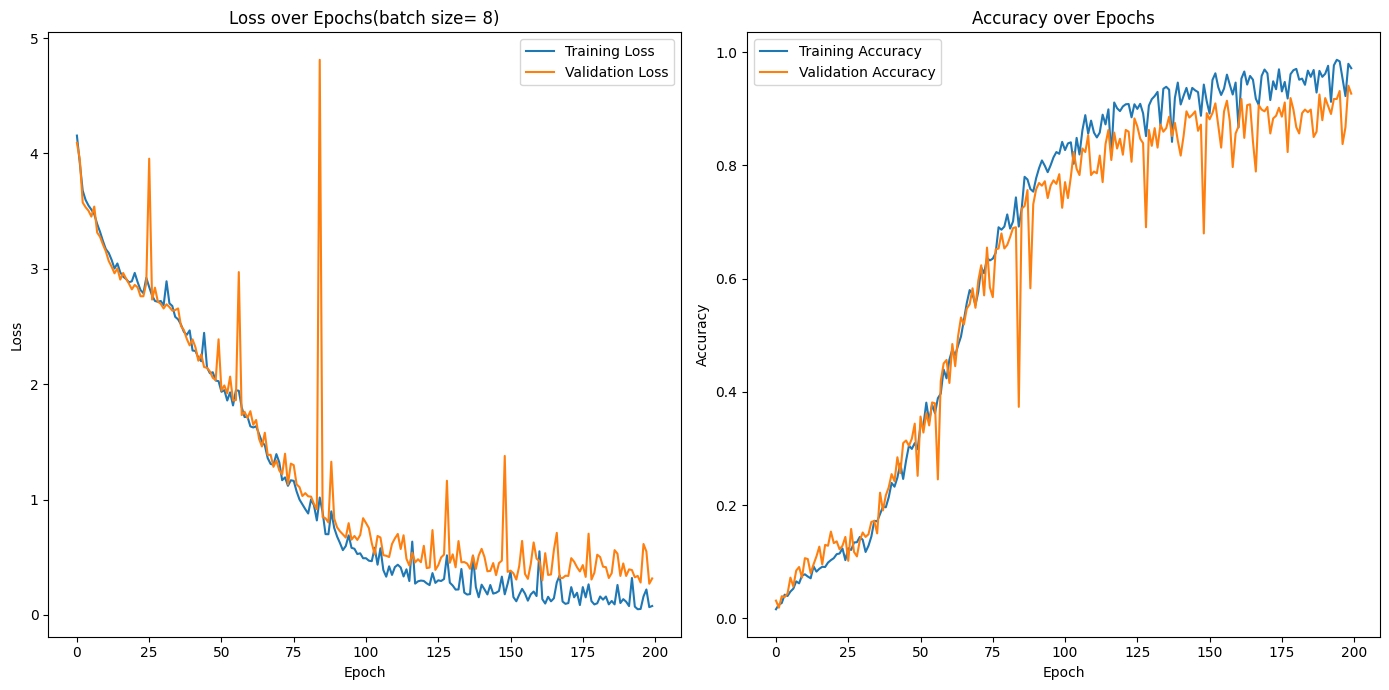

In [57]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')  # or use train_losses_cpu if converted
plt.plot(test_losses, label='Validation Loss')  # or use test_losses_cpu if converted
plt.title('Loss over Epochs(batch size= 8)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_cpu, label='Training Accuracy')
plt.plot(test_accuracies_cpu, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

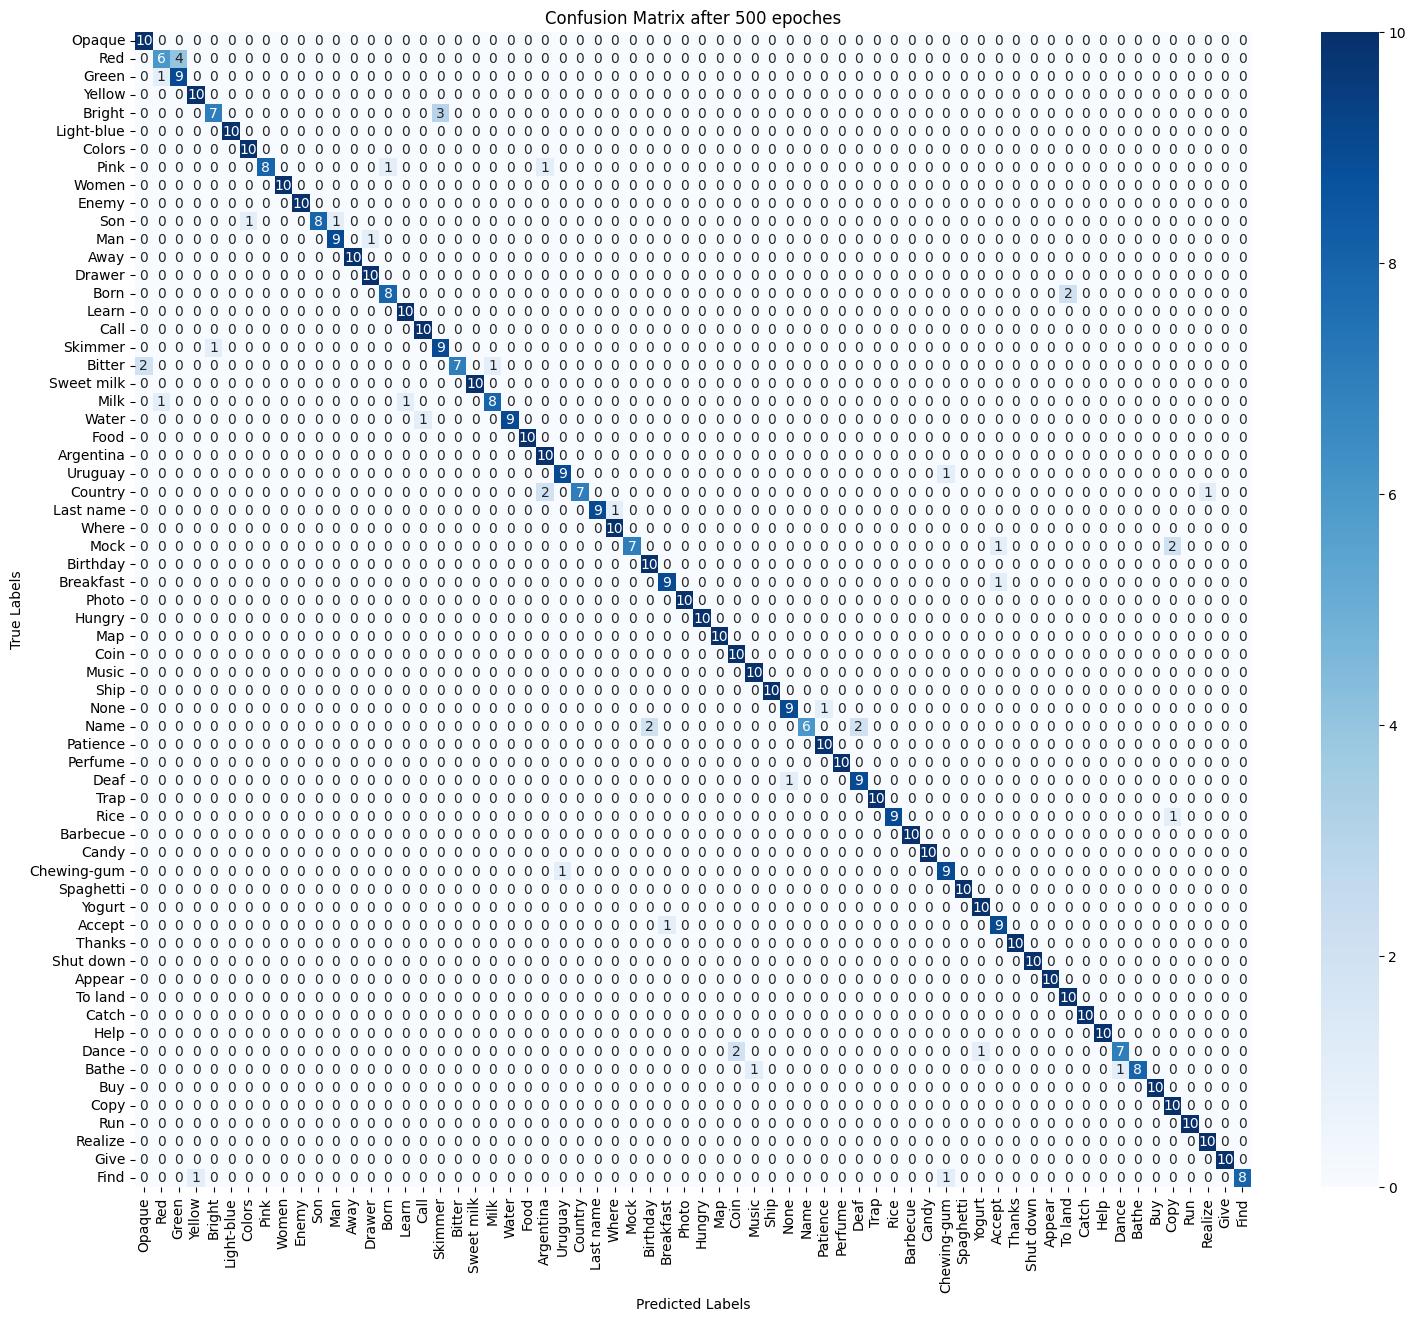

In [73]:
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names= ['Opaque', 'Red', 'Green', 'Yellow', 'Bright', 'Light-blue', 'Colors', 'Pink',
              'Women', 'Enemy', 'Son', 'Man', 'Away', 'Drawer', 'Born', 'Learn',
              'Call', 'Skimmer', 'Bitter', 'Sweet milk', 'Milk', 'Water', 'Food', 'Argentina',
              'Uruguay', 'Country', 'Last name', 'Where', 'Mock', 'Birthday', 'Breakfast', 'Photo',
              'Hungry', 'Map', 'Coin', 'Music', 'Ship', 'None', 'Name', 'Patience',
              'Perfume', 'Deaf', 'Trap', 'Rice', 'Barbecue', 'Candy', 'Chewing-gum', 'Spaghetti',
              'Yogurt', 'Accept', 'Thanks', 'Shut down', 'Appear', 'To land', 'Catch', 'Help',
              'Dance', 'Bathe', 'Buy', 'Copy', 'Run', 'Realize', 'Give', 'Find']

plt.figure(figsize=(18, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix after 500 epoches')
plt.show()

As seen in the confusion matrix above lable 2 and 3 are where the model is making mistak. after watching the videos they were pretty similar sign language gestures.

# Function for getting predictions with LSTM

In [60]:
def get_predictions(video_path, class_names, lstm_model, device):
    frame_numbers= 30
    vid_idx_to_class_name= {i+1:label for i, label in enumerate(class_names)}
    with mp.solutions.holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence=0.5) as holistic:
        cap = cv2.VideoCapture(video_path)              # Read each video using cv2
        if not cap.isOpened():                          # if cv2 can't read the video
            print("unable to read the video")
            return
        else:                                           # if cap can read the video
            total_frames_number = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))                                # getting the total frames in video
            frame_idxs_to_process = np.linspace(0, total_frames_number-1, frame_numbers, dtype=int)     # picking desiered frame indexes
            video_detections= []
            for idx in frame_idxs_to_process:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame= cap.read()
            
                result= holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                pose= np.array([[res.x, res.y, res.z, res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(33*4) 
                face= np.array([[res.x, res.y, res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(468*3) 
                lh= np.array([[res.x, res.y, res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
                rh= np.array([[res.x, res.y, res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)
                detection= np.concatenate((pose, face, lh,rh))
                label= vid_idx_to_class_name[int(os.path.basename(video_path).split('_')[0])]
                video_detections.append(detection)
                input_tensor = torch.tensor([video_detections], dtype=torch.float32).to(device)

            lstm_model.eval()

            # Make a prediction
            with torch.no_grad():
                output = lstm_model(input_tensor)
                    
            # Assuming the output is logits and this is a classification task
            # Convert logits to probabilities and determine the predicted class
            probabilities = torch.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1)
            predicted_class = predicted_class.item()
            predicted_class = class_names[predicted_class]


            print(f"Predicted Class: {predicted_class}, label: {label}")
            cap.release()

In [61]:
video_path= 'lsa64_raw/all/001_003_001.mp4'

In [62]:
get_predictions(video_path, class_names, lstm_model, device)

C:\Users\sadeg\AppData\Local\Temp\ipykernel_9440\482741117.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  input_tensor = torch.tensor([video_detections], dtype=torch.float32).to(device)


Predicted Class: Opaque, label: Opaque


# Building Random Forest Model

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
x_train_reshaped = torch.reshape(X_train, (2560, -1))
x_test_reshaped = torch.reshape(X_test, (640, -1))

random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(x_train_reshaped, y_train)

RandomForestClassifier(random_state=42)

# Visualizing RF Results

In [65]:
accuracy = random_forest_model.score(x_test_reshaped, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9890625


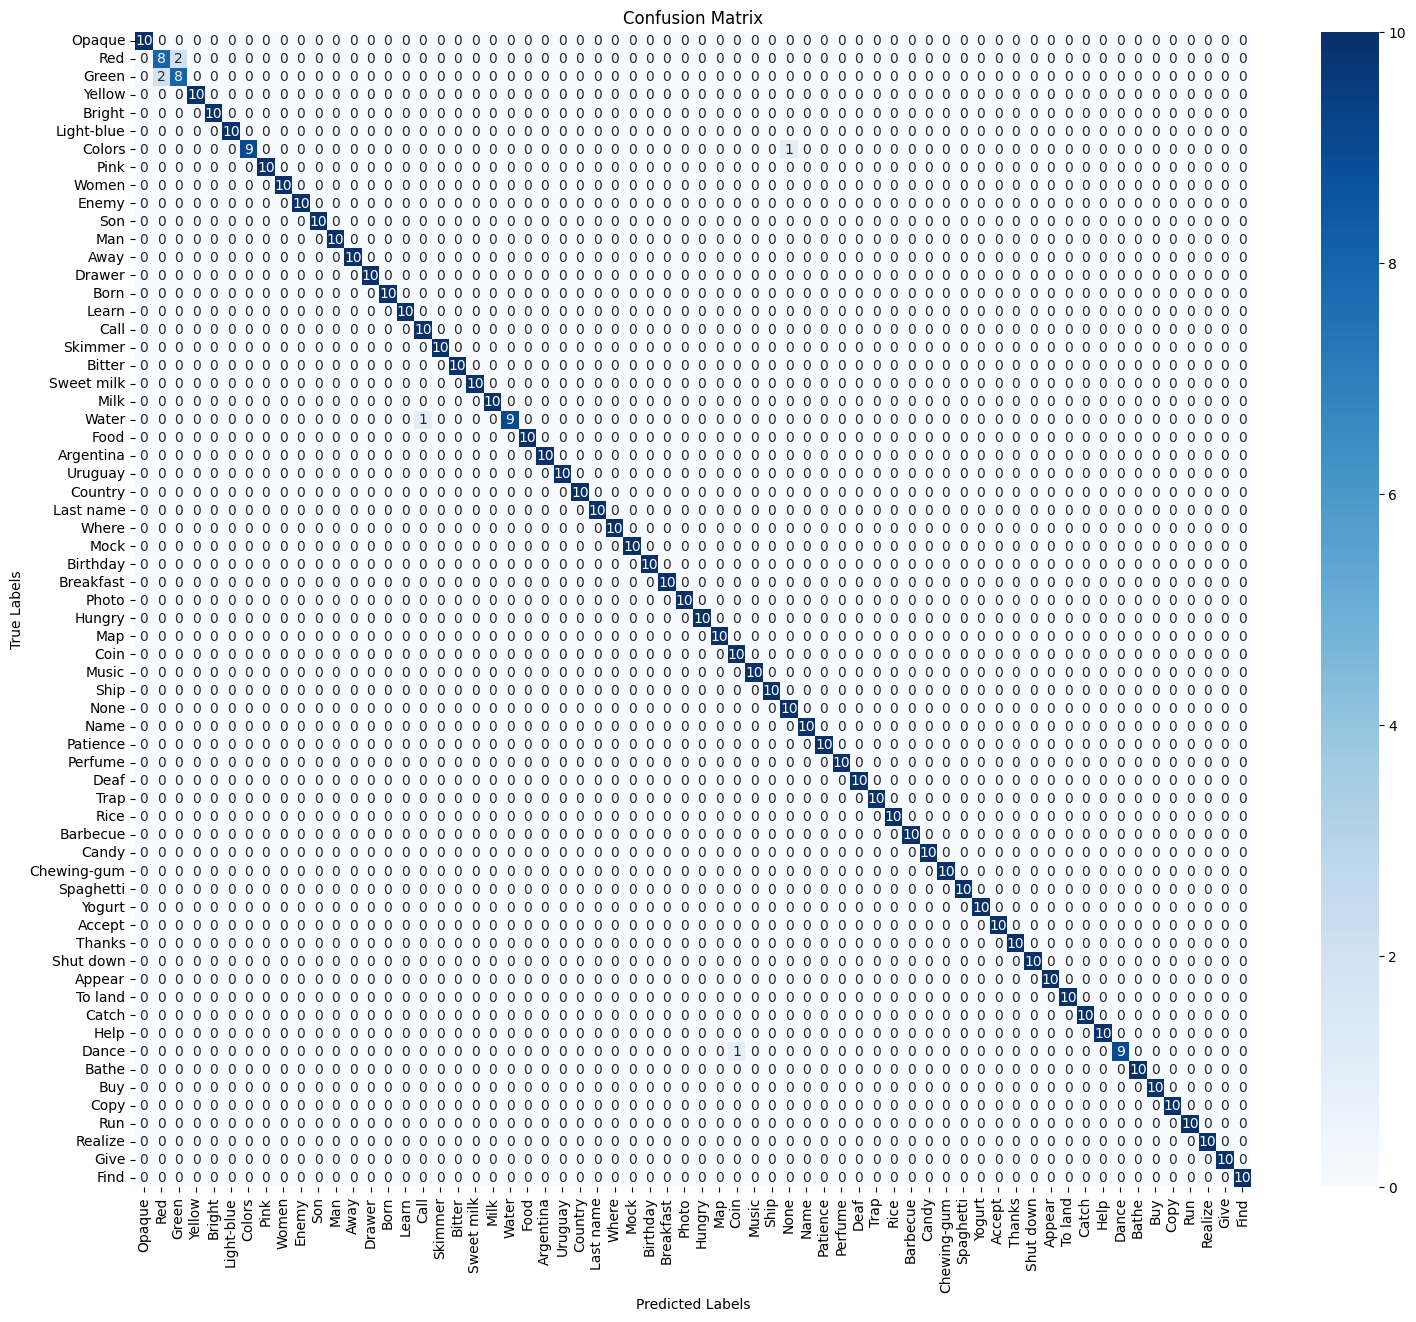

In [72]:
predictions = random_forest_model.predict(x_test_reshaped)

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)


# Get class labels based on one-hot encoded matrix
class_names= ['Opaque', 'Red', 'Green', 'Yellow', 'Bright', 'Light-blue', 'Colors', 'Pink',
              'Women', 'Enemy', 'Son', 'Man', 'Away', 'Drawer', 'Born', 'Learn',
              'Call', 'Skimmer', 'Bitter', 'Sweet milk', 'Milk', 'Water', 'Food', 'Argentina',
              'Uruguay', 'Country', 'Last name', 'Where', 'Mock', 'Birthday', 'Breakfast', 'Photo',
              'Hungry', 'Map', 'Coin', 'Music', 'Ship', 'None', 'Name', 'Patience',
              'Perfume', 'Deaf', 'Trap', 'Rice', 'Barbecue', 'Candy', 'Chewing-gum', 'Spaghetti',
              'Yogurt', 'Accept', 'Thanks', 'Shut down', 'Appear', 'To land', 'Catch', 'Help',
              'Dance', 'Bathe', 'Buy', 'Copy', 'Run', 'Realize', 'Give', 'Find']

# Visualize confusion matrix
plt.figure(figsize=(18, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Function for getting predictions with RF

In [70]:
def get_predictions_rf(video_path, class_names, random_forest_model):
    frame_numbers = 30
    vid_idx_to_class_name = {i+1: label for i, label in enumerate(class_names)}
    with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        cap = cv2.VideoCapture(video_path) # Read each video using cv2
        if not cap.isOpened(): # if cv2 can't read the video
            print("unable to read the video")
            return
        else: # if cap can read the video
            total_frames_number = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # getting the total frames in video
            frame_idxs_to_process = np.linspace(0, total_frames_number-1, frame_numbers, dtype=int) # picking desired frame indexes
            video_detections = []
            for idx in frame_idxs_to_process:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()

                result = holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                pose = np.array([[res.x, res.y, res.z, res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(33*4)
                face = np.array([[res.x, res.y, res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(468*3)
                lh= np.array([[res.x, res.y, res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
                rh = np.array([[res.x, res.y, res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)
                detection = np.concatenate((pose, face,lh, rh))
                video_detections.append(detection)

            # Reshape video_detections to (30*1662,)
            video_detections_reshaped = np.array(video_detections).reshape(-1)

            # Make a prediction using the Random Forest model
            prediction = random_forest_model.predict([video_detections_reshaped])

            # Assuming the prediction is a class label
            predicted_class = class_names[prediction[0]]

            # Extract the true label from the video path
            label = vid_idx_to_class_name[int(os.path.basename(video_path).split('_')[0])]

            print(f"Predicted Class: {predicted_class}, label: {label}")
            cap.release()

In [71]:
get_predictions_rf('lsa64_raw/all/009_009_004.mp4', class_names, random_forest_model)

Predicted Class: Women, label: Women


# Building Transformer classifier

In [74]:
class SimpleSPOTER(nn.Module):
    def __init__(self, num_classes= 64, seq_len=30, landmarks=1662, hidden_dim=128, nhead=4, num_layers=2):
        super(SimpleSPOTER, self).__init__()

        
        self.seq_len = seq_len
        self.landmarks = landmarks
        self.input_proj = nn.Linear(landmarks, hidden_dim)
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_len, hidden_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.linear_class = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs):
        batch_size, seq_len, _ = inputs.shape
        inputs_proj = self.input_proj(inputs.view(batch_size * seq_len, -1)).view(batch_size, seq_len, -1)
        
        # Adding positional encodings
        inputs_encoded = inputs_proj + self.pos_encoder
        
        # Passing through the transformer encoder
        transformer_output = self.transformer_encoder(inputs_encoded)
        
        # Using only the output from the last time step for classification
        output = self.linear_class(transformer_output[:, -1, :])
        
        return output

In [75]:
test_model = SimpleSPOTER()
test_model.to(device)
summary(test_model, input_size=(1, 30, 1662))

Layer (type:depth-idx)                        Output Shape              Param #
SimpleSPOTER                                  [1, 64]                   3,840
├─Linear: 1-1                                 [30, 128]                 212,864
├─TransformerEncoder: 1-2                     [1, 30, 128]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 30, 128]              593,024
│    │    └─TransformerEncoderLayer: 3-2      [1, 30, 128]              593,024
├─Linear: 1-3                                 [1, 64]                   8,256
Total params: 1,411,008
Trainable params: 1,411,008
Non-trainable params: 0
Total mult-adds (M): 6.39
Input size (MB): 0.20
Forward/backward pass size (MB): 0.03
Params size (MB): 0.88
Estimated Total Size (MB): 1.12

# Initializing model

In [76]:
train_dataset= CustomDataset(X_train, y_train)
test_dataset= CustomDataset(X_test, y_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=0, shuffle=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size=64, num_workers=0, shuffle=False) 

model = SimpleSPOTER()
model.to(device)

criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

def calculate_accuracy(y_pred, y_true):
    _, predictions = torch.max(y_pred, 1)
    correct = (predictions == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [77]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    
    for inputs, labels in train_dataloader:
        # Adjusting for the expected input dimensions of SPOTER model if necessary
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, labels)
    
    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(train_accuracy / len(train_dataloader))

    all_preds = []
    all_labels = []
    
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_accuracy += calculate_accuracy(outputs, labels)
            
            _, preds = torch.max(outputs, 1)  # Get the predicted labels
            all_preds.extend(preds.view(-1).cpu().numpy())  # Store predictions
            all_labels.extend(labels.view(-1).cpu().numpy())  # Store true labels
            

    test_losses.append(test_loss / len(test_dataloader))
    test_accuracies.append(test_accuracy / len(test_dataloader))
    #print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Accuracy: {test_accuracies[-1]}')

  0%|          | 0/100 [00:00<?, ?it/s]

In [78]:
# after training i needed to convert the accuracies to cpu arrays so i could draw them.
train_accuracies_cpu = [x.cpu().item() for x in train_accuracies] 
test_accuracies_cpu = [x.cpu().item() for x in test_accuracies]

# Visualizing Transformer classifier Results

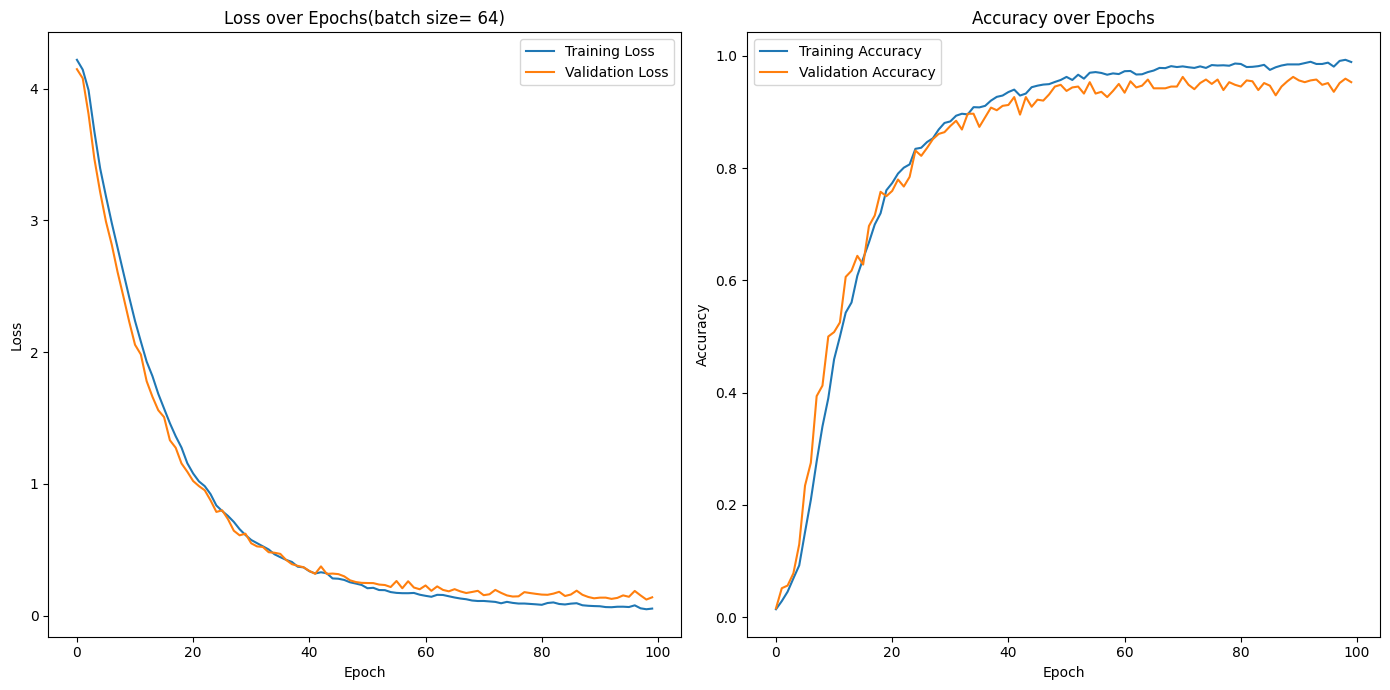

In [82]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')  # or use train_losses_cpu if converted
plt.plot(test_losses, label='Validation Loss')  # or use test_losses_cpu if converted
plt.title('Loss over Epochs(batch size= 64)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_cpu, label='Training Accuracy')
plt.plot(test_accuracies_cpu, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

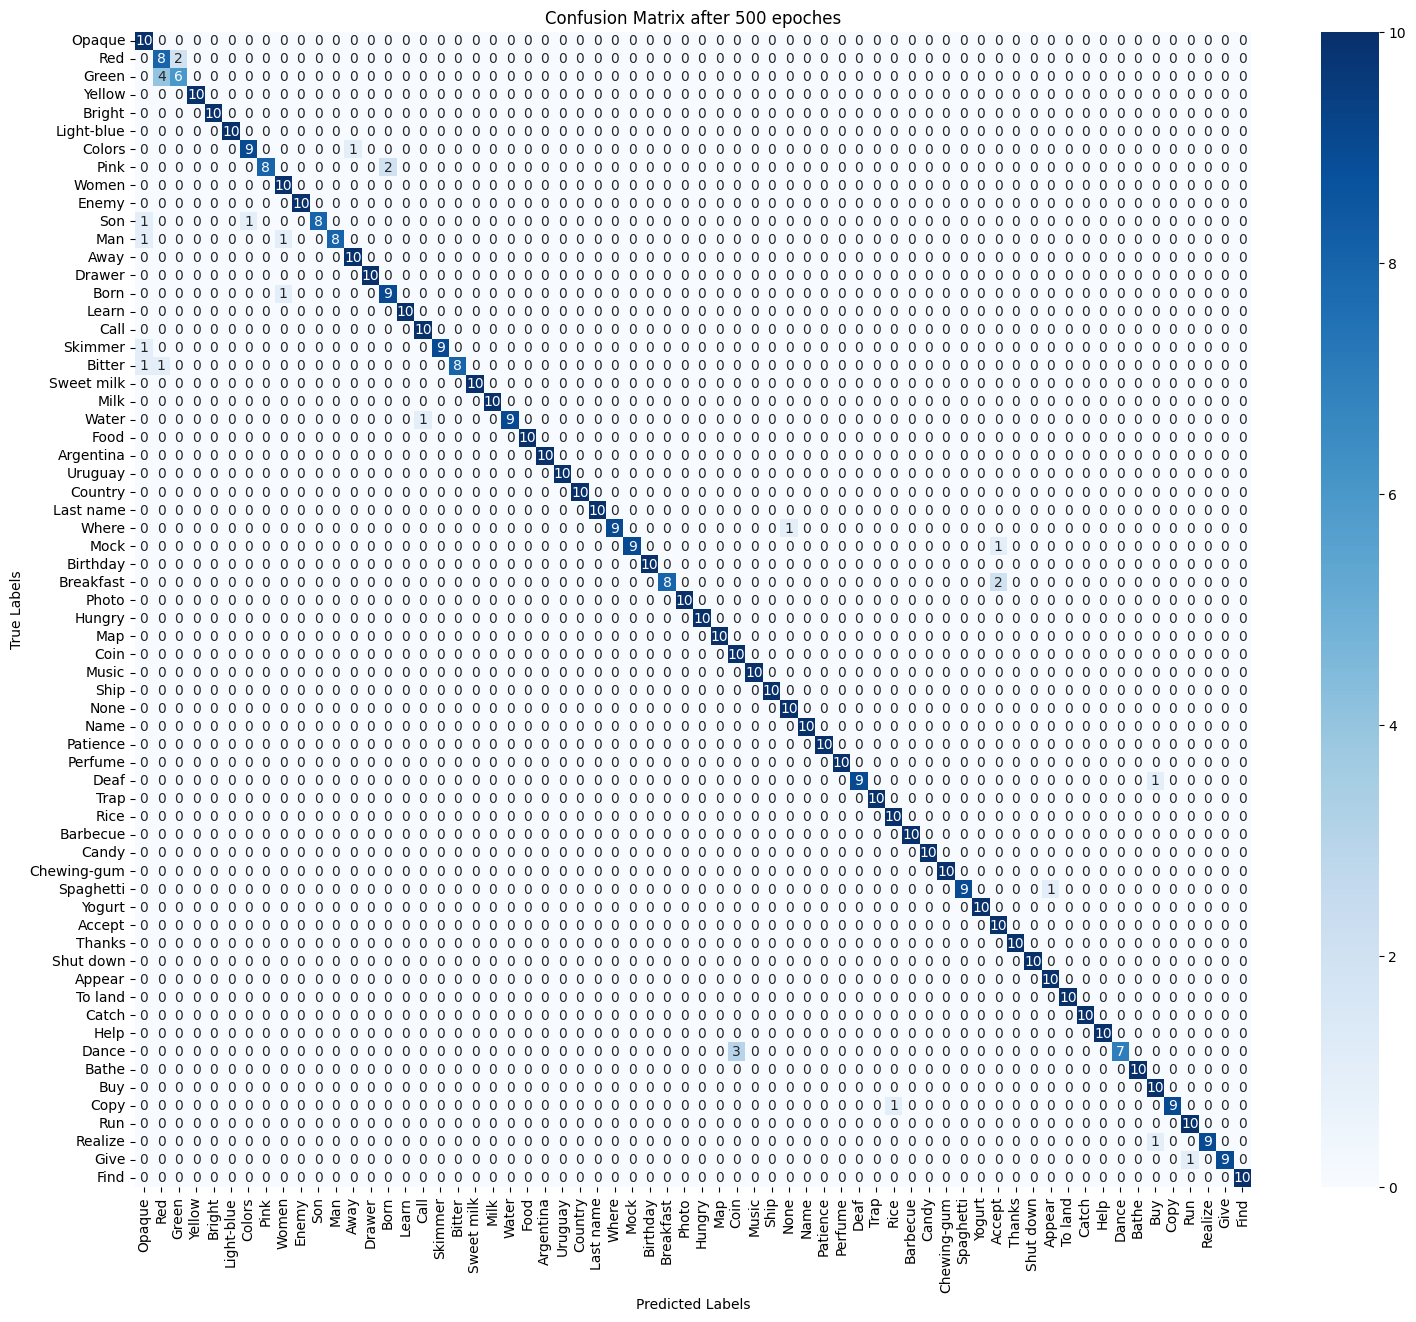

In [81]:
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names= ['Opaque', 'Red', 'Green', 'Yellow', 'Bright', 'Light-blue', 'Colors', 'Pink',
              'Women', 'Enemy', 'Son', 'Man', 'Away', 'Drawer', 'Born', 'Learn',
              'Call', 'Skimmer', 'Bitter', 'Sweet milk', 'Milk', 'Water', 'Food', 'Argentina',
              'Uruguay', 'Country', 'Last name', 'Where', 'Mock', 'Birthday', 'Breakfast', 'Photo',
              'Hungry', 'Map', 'Coin', 'Music', 'Ship', 'None', 'Name', 'Patience',
              'Perfume', 'Deaf', 'Trap', 'Rice', 'Barbecue', 'Candy', 'Chewing-gum', 'Spaghetti',
              'Yogurt', 'Accept', 'Thanks', 'Shut down', 'Appear', 'To land', 'Catch', 'Help',
              'Dance', 'Bathe', 'Buy', 'Copy', 'Run', 'Realize', 'Give', 'Find']

plt.figure(figsize=(18, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix after 500 epoches')
plt.show()